# I - Hidden Trigger Backdoor Attack

## 1. Import Dependencies

In [1]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

import torch
from torch import Tensor
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torch.nn.parameter import Parameter
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, TensorDataset, ConcatDataset, Dataset, random_split

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

### 1-a. Check if any GPU is available

In [2]:
# Use GPU if available

if torch.cuda.is_available():
    device = torch.device("cuda")   
else:
    device = torch.device("cpu")

print(f"Using {device}")

Using cuda


## 2. Load Dataset

### 2-a. Extract data with labelled as airplane and truck

In [3]:
torch.manual_seed(2)

# Load a tool to convert the dataset into Tensor used by PyTorch
to_tensor = transforms.Compose([
        transforms.ToTensor(),
    ])

# Download CIFAR-10 dataset from PyTorch
train_dataset = datasets.CIFAR10('./data', train=True, download=True, transform=to_tensor) # (50000, 32, 32, 3)
test_dataset = datasets.CIFAR10('./data', train=False, download=True, transform=to_tensor) # (10000, 32, 32, 3)   

# Create subset indices
train_subset_size = 5000
test_subset_size = 500
clean_test_subset_size = 100

# Get the indices for airplane and bird
class_names = train_dataset.classes
airplane_index = class_names.index("airplane") # 0
truck_index = class_names.index("truck") # 9

# Filter indices only from airplane and bird classes in the train set
train_airplane_bird_indices = []
for i, (image, label) in enumerate(train_dataset):
    if label in [airplane_index, truck_index]:
        train_airplane_bird_indices.append(i)
train_airplane_bird_indices = torch.tensor(train_airplane_bird_indices[:train_subset_size])

# Filter indices only from airplane and bird classes in the test set
test_airplane_bird_indices = []
for i, (image, label) in enumerate(test_dataset):
    if label in [airplane_index, truck_index]:
        test_airplane_bird_indices.append(i)
test_airplane_bird_indices = torch.tensor(test_airplane_bird_indices[:test_subset_size])

# Create a subset that only contains airplanes and birds
train_subset = Subset(train_dataset, train_airplane_bird_indices)
test_subset = Subset(test_dataset, test_airplane_bird_indices)

# Create a clean dataset by spliting the test subset
remaining_size = len(test_subset) - clean_test_subset_size
clean_test_subset, test_subset = random_split(test_subset, [clean_test_subset_size, remaining_size]) 

# Remap truck label from 9 to 1 in the train set
for i in train_airplane_bird_indices:
    if train_dataset.targets[i] == truck_index:
        train_dataset.targets[i] = 1  # relabel truck to 1

# Remap truck label from 9 to 1 in the test set
for i in test_airplane_bird_indices:
    if test_dataset.targets[i] == truck_index:
        test_dataset.targets[i] = 1  # relabel truck to 1

# Now there are only 2 class types
class_names = ['airplane', 'truck']

# Load the dataset into DataLoader
train_dataloader = DataLoader(train_subset, batch_size=64, shuffle=True)
# print(len(train_dataloader.dataset)) # 5000
test_dataloader = DataLoader(test_subset, batch_size=64, shuffle=False)
# print(len(test_dataloader.dataset)) # 400

0.0%

100.0%


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### 2-b. Plot 10 Random Data Samples

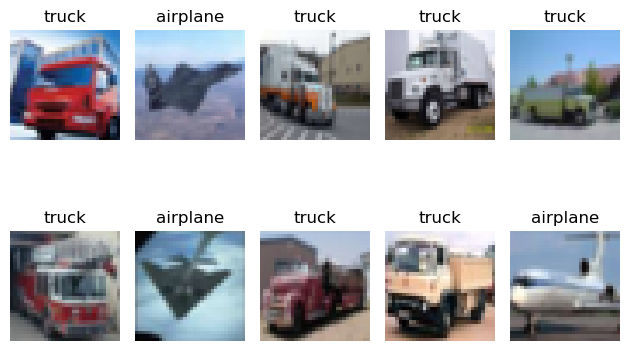

In [4]:
data_iter = iter(train_dataloader)
samples = next(data_iter)

def plot_images(instances, labels):
    for i in range(len(instances)):
        plt.subplot(2, 5, i+1)
        plt.imshow( torch.transpose (torch.transpose(instances[i].squeeze(), 0, 1), 1, 2) ) # convert [3, 32, 32] to [32, 32, 3]
        plt.title(class_names[labels[i]]) # type(labels[i]) should be tensor(0) or tensor(1)
        plt.axis("off")

first_10_images = samples[0][:10] # first_10_images.shape = [10, 3, 32, 32]
first_10_labels = samples[1][:10] # first_10_labels.shape = [10]

plot_images(first_10_images, first_10_labels)
plt.tight_layout()
plt.show()

## 3. Construct a simple CNN for binary image classification

In [5]:
class simpleCNN(nn.Module):
    def __init__(self):
        super(simpleCNN, self).__init__()
     
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.conv_layer2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.max_pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.conv_layer3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv_layer4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        self.max_pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.fc1 = nn.Linear(1600, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 1) # 1 = binary classification 
        
    def forward(self, x):
        x = self.conv_layer1(x)
        x = self.conv_layer2(x)
        x = self.max_pool1(x)
        x = self.conv_layer3(x)
        x = self.conv_layer4(x)
        x = self.max_pool2(x)              
        x = x.reshape(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        return x
    
    def get_task_specific_features(self, x):
        x = self.conv_layer1(x)
        x = self.conv_layer2(x)
        x = self.max_pool1(x)
        x = self.conv_layer3(x)
        x = self.conv_layer4(x)
        x = self.max_pool2(x)              
        x = x.reshape(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu1(x)
        return x
        

# instantiate the model from CNN class above
clean_model = simpleCNN() 
clean_model.to(device)
print(f"Using {device} to train model\n")

# print out the structure of the model
print(clean_model)

Using cuda to train model

simpleCNN(
  (conv_layer1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv_layer2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_layer3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv_layer4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1600, out_features=128, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)


### 3-a. Define hyperparameters

In [6]:
np.random.seed(2)
torch.manual_seed(2)

epochs = 20
learning_rate = 0.01
weight_decay = 0.005

lossfunction = nn.BCEWithLogitsLoss() # use cross binary entropy loss

optimizer = optim.Adam(clean_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

### 3-b. Define a function for training

In [7]:
train_accuracy_flow = []

def train(epoch, model, train_dataloader, optimizer, lossfunction):
    model.train()

    train_loss = 0.0
    train_total, train_correct = 0.0, 0.0

    for X_batch, y_batch in train_dataloader:
        # move tensors to the CUDA gpu if available
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # reset the gradient on every batch time
        optimizer.zero_grad() 

        y_batch = y_batch.float().unsqueeze(1)
        
        # get the prediction with respect to the train data batch
        train_predictions = model(X_batch)

        # use the defined loss function to calculate the train loss
        y_batch = y_batch.view(-1, 1).float()
        loss = lossfunction(train_predictions, y_batch)

        # update the weight using the gradient descent with Adam optimizer
        loss.backward()
        optimizer.step()

        # convert probabilities to multi-class predictions
        # and return the class with the maximum probability
        train_predicted = (train_predictions >= 0.5).float()
        # _, train_predicted = torch.max(train_predictions.data, 1)

        # update training loss
        train_loss += loss.item()

        # calculate the training statistics
        train_total += y_batch.size(0)
        train_correct += (train_predicted == y_batch).sum().item()
    
    # For the result graph
    train_accuracy_flow.append(train_correct/train_total)

    # plot the result
    print("Epoch (%d): Train accuracy: %.4f, loss: %.3f" % (epoch, train_correct/train_total, train_loss/train_total))

### 3-c. Define a function for testing

In [8]:
def test(model, test_dataloader):
    model.eval()

    test_correct, test_total = 0.0, 0.0
    y_test, y_pred = [], []
    y_pred = []

    # disable gradient calculation
    with torch.no_grad():
        for X_batch, y_batch in test_dataloader:
            # move tensors to the CUDA gpu if available
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                
            y_batch = y_batch.float().unsqueeze(1)
            
            # get the prediction with respect to the test data batch
            test_predictions = model(X_batch)
            
            # convert probabilities to multi-class predictions
            # and return the class with the maximum probability
            test_predicted = (test_predictions >= 0.5).float()
            # _, test_predicted = torch.max(test_predictions.data, 1)

            # calculate the testing statistics
            test_total += y_batch.size(0)
            test_correct += (test_predicted == y_batch).sum().item()
            y_test += y_batch.tolist()
            y_pred += test_predicted.tolist()

    # calculate the F1 score
    f1 = f1_score(y_test, y_pred)
    print("Test accuracy: %.4f, F1 score: %.4f" % (test_correct / test_total, f1))

    # plot the confusion matrix
    cfmt = confusion_matrix(y_test, y_pred)
    cfmt_display = ConfusionMatrixDisplay(confusion_matrix=cfmt, display_labels=class_names)
    fig, ax = plt.subplots()
    cfmt_display.plot(ax=ax)
    ax.set_title("<Confusion Matrix for Testing>")
    plt.show()

### 3-d. Define a function that returns a predicted label for a single input

In [9]:
def predict_label(model, single_input):
    model.eval()

    # disable gradient calculation
    with torch.no_grad():
        # use GPU if available
        single_input = single_input.to(device)

        # get the prediction with respect to the single input
        prediction = model(single_input)

        # convert probabilities to multi-class predictions
        # and return the class with| the maximum probability
        predicted_label = (prediction >= 0.5).float()
        # _, predicted_label = torch.max(prediction.data, 1)

    return predicted_label

### 3-e. Define a function that converts the raw dataset to PyTorch Tensor

In [10]:
class WrappedDataset(Dataset):
    def __init__(self, base_dataset):
        self.base_dataset = base_dataset
    
    def __getitem__(self, index):
        x, y = self.base_dataset[index]
        return x, torch.tensor(y, dtype=torch.long)
    
    def __len__(self):
        return len(self.base_dataset)

## 4. Train the model

Epoch (1): Train accuracy: 0.5682, loss: 0.082
Epoch (2): Train accuracy: 0.7256, loss: 0.008
Epoch (3): Train accuracy: 0.7466, loss: 0.008
Epoch (4): Train accuracy: 0.7460, loss: 0.008
Epoch (5): Train accuracy: 0.7634, loss: 0.008
Epoch (6): Train accuracy: 0.8198, loss: 0.006
Epoch (7): Train accuracy: 0.8314, loss: 0.006
Epoch (8): Train accuracy: 0.8378, loss: 0.006
Epoch (9): Train accuracy: 0.8354, loss: 0.006
Epoch (10): Train accuracy: 0.8402, loss: 0.006
Epoch (11): Train accuracy: 0.8490, loss: 0.005
Epoch (12): Train accuracy: 0.8590, loss: 0.005
Epoch (13): Train accuracy: 0.8670, loss: 0.005
Epoch (14): Train accuracy: 0.8620, loss: 0.005
Epoch (15): Train accuracy: 0.8726, loss: 0.005
Epoch (16): Train accuracy: 0.8834, loss: 0.004
Epoch (17): Train accuracy: 0.8862, loss: 0.004
Epoch (18): Train accuracy: 0.8706, loss: 0.005
Epoch (19): Train accuracy: 0.8900, loss: 0.004
Epoch (20): Train accuracy: 0.8842, loss: 0.004


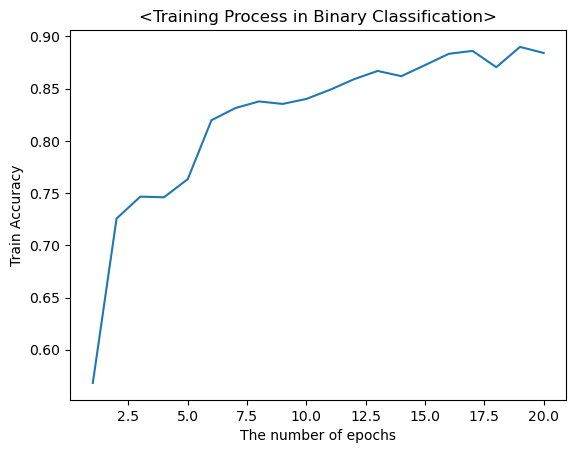

In [11]:
num_of_epochs = []

for epoch in range(1, epochs + 1):
    num_of_epochs.append(epoch)
    train(epoch, clean_model, train_dataloader, optimizer, lossfunction)

plt.figure()
plt.title("<Training Process in Binary Classification>")
plt.xlabel("The number of epochs")
plt.ylabel("Train Accuracy")
plt.plot(num_of_epochs, train_accuracy_flow)
plt.show()

## 5. Test the trained model

Test accuracy: 0.8850, F1 score: 0.8856


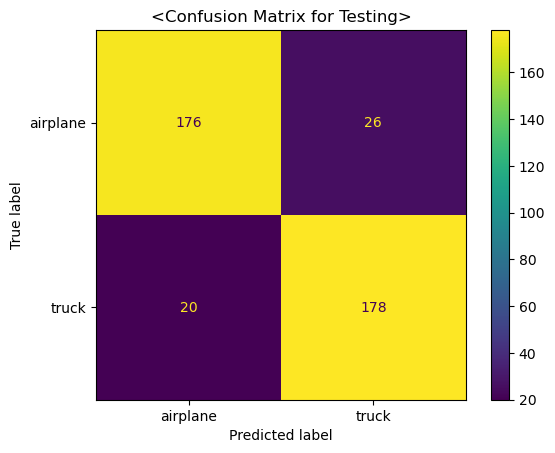

In [12]:
test(clean_model, test_dataloader) 

## 6. Set Up Hidden Trigger Attack


Choose a subset of base instances (base label `c`) and a subset of target instances (label(s) that are different from `c`) for attack from the training images.

Hidden trigger backdoor attack is to add trojan trigger patten to target instances first, and then perturb base images toward these target instances (with trojan trigger) to generate the perturbed images, which are the final poisoned images. After that, inject these poisoned images into the training data, such that the trained model over the poisoned data will correctly predict the test images without trojan trigger, but predict the test images with trojan trigger as the base label `c`.


Base instances:


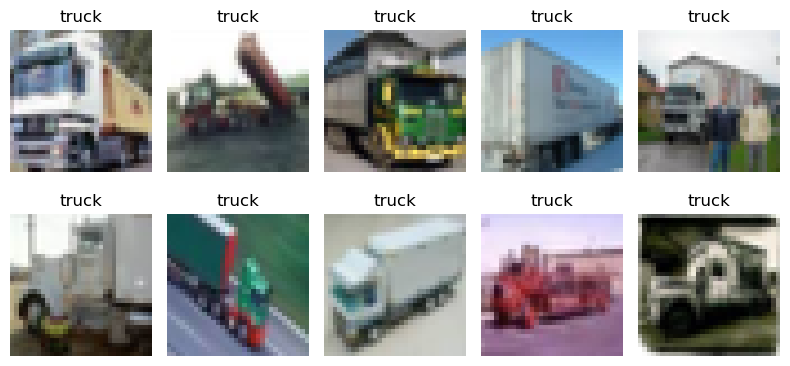


Target instances:


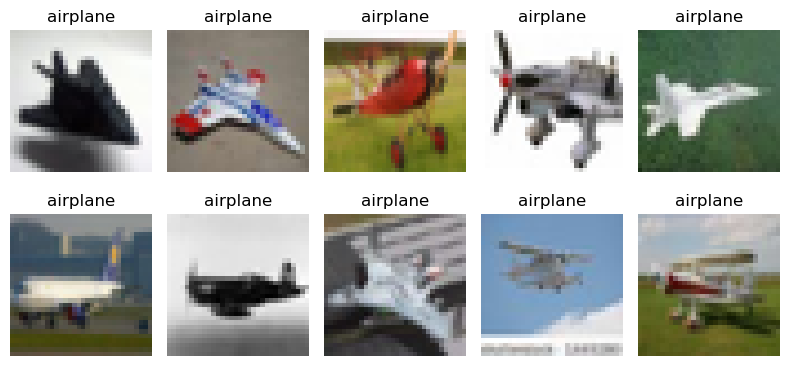

In [13]:
# Choose a base label: all the images with trojan trigger should be classified as this label
base_label_name = "truck"
base_label_index = class_names.index(base_label_name)

# Obtain all the base instances and target instances
base_instances = []
base_labels = []
target_instances = []
target_labels = []

for samples, labels in train_subset:
    if labels == base_label_index:
        base_instances.append(samples)
        base_labels.append(labels)
    elif labels != base_label_index:
        target_instances.append(samples)
        target_labels.append(labels)

base_instances = torch.stack(base_instances) 
# print(base_instances.shape) # torch.Size([2493, 3, 32, 32])
target_instances = torch.stack(target_instances) 
# print(target_instances.shape) # torch.Size([2507, 3, 32, 32])

# Plot some base instances
fig, ax = plt.subplots(2, 5, figsize=(8, 4))
example_images = base_instances[:10]
example_labels = base_labels[:10]
plot_images(example_images, example_labels)
plt.tight_layout()
print("Base instances:")
plt.show()

# Plot some target instances
fig, ax = plt.subplots(2, 5, figsize=(8, 4))
example_images = target_instances[:10]
example_labels = target_labels[:10]
plot_images(example_images, example_labels)
plt.tight_layout()
print("\nTarget instances:")
plt.show()

### 6-a. Add a trojan trigger to the target instances

Trojan trigger:


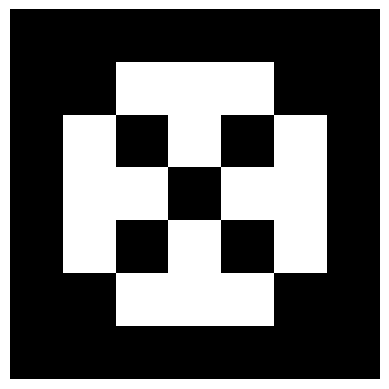

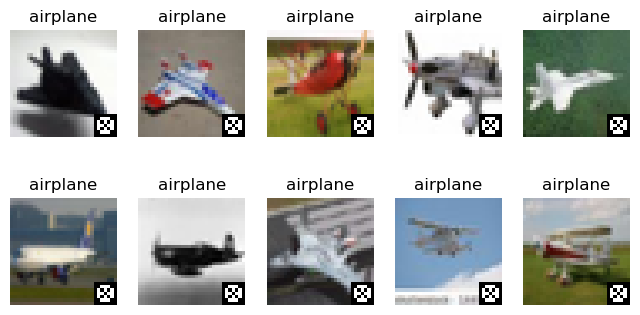

In [14]:
# generate the trigger
# trojan_trigger = torch.Tensor([0.]).repeat(10, 10)
trojan_trigger = np.array([[0, 0, 0, 0, 0, 0, 0],
                           [0, 0, 1, 1, 1, 0, 0],
                           [0, 1, 0, 1, 0, 1, 0],
                           [0, 1, 1, 0, 1, 1, 0],
                           [0, 1, 0, 1, 0, 1, 0],
                           [0, 0, 1, 1, 1, 0, 0],
                           [0, 0, 0, 0, 0, 0, 0]])
print("Trojan trigger:")
plt.imshow(trojan_trigger, cmap='gray')
plt.axis("off")

trojan_trigger = torch.tensor(trojan_trigger)

# add the trigger to the target instances
triggered_instances = target_instances.clone()
triggered_instances[:, 0, 25:32, 25:32] = trojan_trigger # at the R channel
triggered_instances[:, 1, 25:32, 25:32] = trojan_trigger # at the G channel
triggered_instances[:, 2, 25:32, 25:32] = trojan_trigger # at the B channel

# plot some perturbed instances with the trojan trigger
fig, ax = plt.subplots(2, 5, figsize=(8, 4))
example_images = triggered_instances[:10]
example_labels = target_labels[:10]
plot_images(example_images, example_labels)
plt.show()

### 6-b. Use feature collision to perturb the base instances towards the triggered target instances

In [15]:
class FeatureCollisionNet(nn.Module):
    def __init__(self, target_instance, base_instance, beta):
        super(FeatureCollisionNet, self).__init__()
        self.x = torch.clone(base_instance) # initialize x as a base instance
        self.x = Parameter(self.x, requires_grad=True)  # set x as the model parameter to be optimized
        self.beta = beta # set up the beta

        self.pretrained_model = clean_model # load the trained model to extract the task-specific features        
        self.pretrained_model.eval() # the model won't be updated, will be used only for feature extraction
        for param in self.pretrained_model.parameters():
            param.requires_grad = False

    def get_task_specific_features(self, input_instance):
        output = self.pretrained_model(input_instance)
        return output
    
    def forward(self, target_instance, base_instance):
        x = torch.clamp(self.x, 0, 1)

        # compute task-specific features
        task_specific_x = self.get_task_specific_features(x)
        task_specific_target = self.get_task_specific_features(target_instance)
        
        objective = torch.norm(task_specific_x - task_specific_target, p=2) ** 2 + \
                    self.beta * torch.norm(x - base_instance, p=2) ** 2
        
        return objective

### 6-c. Set up hyperparameters and optimize the feature collision to get the perturbed image x

In [16]:
torch.manual_seed(2)
epochs = 50
learning_rate = 0.1
# learning_rate = 0.001
beta = 1
poisoned_account = 100 # specify the number of poisoning examples we want to generate

poisoned_instances = []

def train_feature_collision_model(i, epoch, feature_collision_model, 
                                  feature_collision_model_optimizer, triggered_instance, base_instance):
    
    # use GPU if available
    feature_collision_model.to(device)
    triggered_instance = triggered_instance.to(device)
    base_instance = base_instance.to(device)

    feature_collision_model.train()
    feature_collision_model_optimizer.zero_grad()
    feature_collision_model_objective = feature_collision_model(triggered_instance, base_instance)
    feature_collision_model_objective.backward()
    feature_collision_model_optimizer.step()

    print("Target instance with trigger: {:d}".format(i+1), " / Epoch: {:d}".format(epoch),
          " / Feature Collision Loss: {:.2f}".format(feature_collision_model_objective.item()))
    
for i in range(poisoned_account):
      # randomly select one target instance with the trigger from triggered instances
      triggered_instance = triggered_instances[torch.randint(0, triggered_instances.size(0), (1,))]
      # randomly select one base instance from base instances
      base_instance = base_instances[torch.randint(0, base_instances.size(0), (1,))]

      parameter_to_update = []
      feature_collision_model = FeatureCollisionNet(triggered_instance, base_instance, beta)
      
      for p in feature_collision_model.parameters():
           if p.requires_grad:
                parameter_to_update.append(p)
                break
           
      feature_collision_model_optimizer = optim.Adam(parameter_to_update, lr=learning_rate)


      for epoch in range(1, epochs+1):
           train_feature_collision_model(i, epoch, feature_collision_model, feature_collision_model_optimizer,
                                         triggered_instance, base_instance)
           
      # the optimized model parameter is the poisoned instance after feature collision
      poisoned_instances.append(torch.clamp(parameter_to_update[0].squeeze(0), 0, 1))

poisoned_instances = torch.stack(poisoned_instances)
print(poisoned_instances.shape)

Target instance with trigger: 1  / Epoch: 1  / Feature Collision Loss: 5.56
Target instance with trigger: 1  / Epoch: 2  / Feature Collision Loss: 32.85
Target instance with trigger: 1  / Epoch: 3  / Feature Collision Loss: 38.42
Target instance with trigger: 1  / Epoch: 4  / Feature Collision Loss: 27.01
Target instance with trigger: 1  / Epoch: 5  / Feature Collision Loss: 21.78
Target instance with trigger: 1  / Epoch: 6  / Feature Collision Loss: 16.37
Target instance with trigger: 1  / Epoch: 7  / Feature Collision Loss: 12.18
Target instance with trigger: 1  / Epoch: 8  / Feature Collision Loss: 10.78
Target instance with trigger: 1  / Epoch: 9  / Feature Collision Loss: 8.28
Target instance with trigger: 1  / Epoch: 10  / Feature Collision Loss: 8.37
Target instance with trigger: 1  / Epoch: 11  / Feature Collision Loss: 9.47
Target instance with trigger: 1  / Epoch: 12  / Feature Collision Loss: 9.92
Target instance with trigger: 1  / Epoch: 13  / Feature Collision Loss: 9.29
T

### 6-d. Plot the poisoned samples

Poisoned instances after feature collision attack:


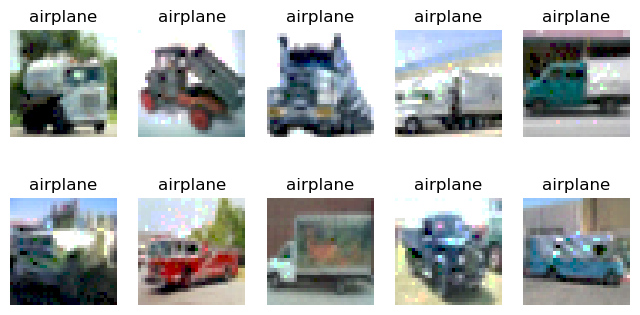

In [17]:
# print(len(poisoned_instances), poisoned_instances.shape) # 100, torch.Size([100, 3, 32, 32])
poisoned_predicted = predict_label(clean_model, poisoned_instances)
# print(len(poisoned_predicted), poisoned_predicted.shape) # 100, torch.Size([100, 1])

poisoned_instances = poisoned_instances.detach()

poisoned_predicted = Tensor.cpu(poisoned_predicted) # load data on CPU to plot
poisoned_instances = Tensor.cpu(poisoned_instances) # load data on CPU to plot

# plot some poisoning instances: the instances should look like the base instance (bird)
# but their task-specific features are closer to the target instances (airplane) with the trojan trigger
fig, ax = plt.subplots(2, 5, figsize=(8, 4))
example_images = poisoned_instances[:10]
example_labels = poisoned_predicted[:10].long() # convert tensor([0.]) to tensor([0])
plot_images(example_images, example_labels)
print("Poisoned instances after feature collision attack:")
plt.show()

### 6-e. Visualize the final poisoned instances

Flipped the label after feature collision attack:


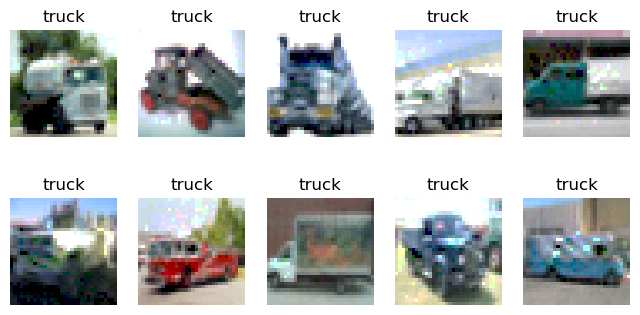

In [18]:
# assign the base label to all poisoned instances
poisoned_labels = torch.full((poisoned_account,), base_label_index, dtype=torch.long)

# plot some original target instances
fig, ax = plt.subplots(2, 5, figsize=(8, 4))
example_images = poisoned_instances[:10]
example_labels = poisoned_labels[:10].long() # convert tensor([0.]) to tensor([0])
plot_images(example_images, example_labels)
print("Flipped the label after feature collision attack:")
plt.show()

## 7. Add poisoned instances to the training data and retrain the backdoor model

In [19]:
# construct a poisoned dataset with the base label
poisoned_dataset = TensorDataset(poisoned_instances, poisoned_labels)

# concatenate the original train_subset and the poisoned dataset to new_train_dataset
train_subset_wrapped = WrappedDataset(train_subset)
poisoned_train_dataset = ConcatDataset([train_subset_wrapped, poisoned_dataset])

# load the datasets into DataLoader
poisoned_train_dataloader = DataLoader(poisoned_train_dataset, batch_size=64, shuffle=True)

# set up hyperparameters for a new backdoor model
epochs = 10
learning_rate = 0.001
weight_decay = 0.005
lossfunction = nn.BCEWithLogitsLoss() # use cross binary entropy loss

backdoor_model = simpleCNN()
backdoor_optimizer = optim.Adam(backdoor_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# use GPU if available
backdoor_model = backdoor_model.to(device)

# retrained the model
for epoch in range(1, epochs+1):
    train(epoch, backdoor_model, poisoned_train_dataloader, backdoor_optimizer, lossfunction)

Epoch (1): Train accuracy: 0.7286, loss: 0.008
Epoch (2): Train accuracy: 0.8231, loss: 0.006
Epoch (3): Train accuracy: 0.8408, loss: 0.006
Epoch (4): Train accuracy: 0.8478, loss: 0.005
Epoch (5): Train accuracy: 0.8700, loss: 0.005
Epoch (6): Train accuracy: 0.8818, loss: 0.004
Epoch (7): Train accuracy: 0.8861, loss: 0.004
Epoch (8): Train accuracy: 0.9014, loss: 0.004
Epoch (9): Train accuracy: 0.9006, loss: 0.004
Epoch (10): Train accuracy: 0.8988, loss: 0.004


## 8. Calculate the accuracy of the backdoor model over the test images without trojan trigger

Test accuracy: 0.8775, F1 score: 0.8734


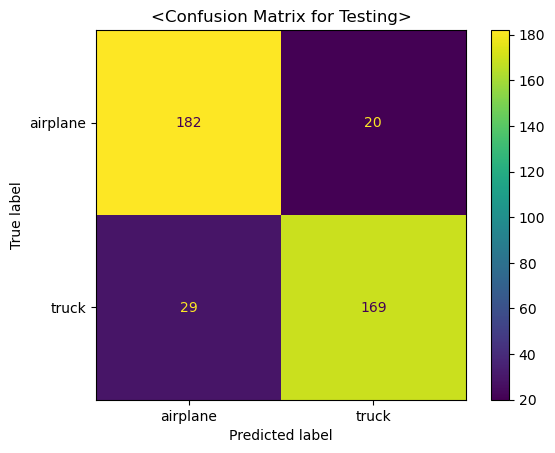

In [20]:
# test the backdoor model
test(backdoor_model, test_dataloader) 

## 9. Add trojan trigger to test images and calculate the accuracy of the backdoor model over these triggered images

Test accuracy: 0.8450, F1 score: 0.8450


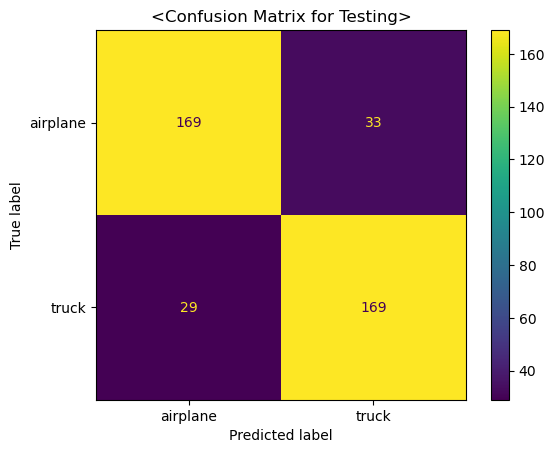

In [21]:
test_instances = []
test_labels = []

# obtain all the test instances whose labels are not the base label (all target labels)
# and then add trigger to these test instances
for samples, labels in test_subset: 
    if labels != base_label_index:
        backdoor_test_instances = samples.clone()
        backdoor_test_instances[0, 25:32, 25:32] = trojan_trigger # at the R channel
        backdoor_test_instances[1, 25:32, 25:32] = trojan_trigger # at the G channel
        backdoor_test_instances[2, 25:32, 25:32] = trojan_trigger # at the B channel
        test_instances.append(backdoor_test_instances)
        test_labels.append(labels)
    elif labels == base_label_index:
        test_instances.append(samples)
        test_labels.append(labels)

test_instances = torch.stack(test_instances) # torch.Size([800, 3, 32, 32])
test_labels = torch.tensor(test_labels) # torch.Tensor, len=800

# construct backdoor test dataset
backdoor_test_dataset = TensorDataset(test_instances, test_labels)
# print(len(test_instances)) # 400

# load the datasets into DataLoader
backdoor_test_dataloader = DataLoader(backdoor_test_dataset, batch_size=64, shuffle=False)
# print(len(backdoor_test_dataloader.dataset)) # 400

# test the backdoor model using all test instances with trigger
test(backdoor_model, backdoor_test_dataloader)

## 10. Case Study: Find some examples

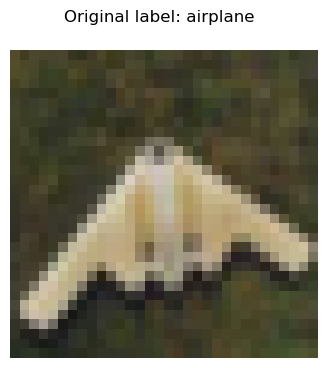

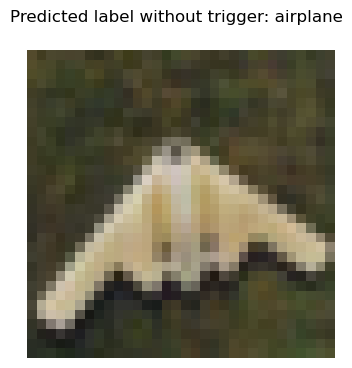

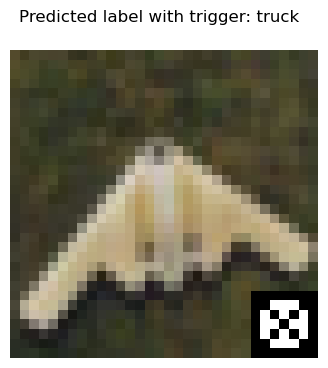

In [39]:
# choose a random test images as input
np.random.seed(2)

# number of test samples
number_of_samples = len(clean_test_subset)

# extract only the indices of target samples in the clean test subset
target_samples_indices = []
for i, (image, label) in enumerate(clean_test_subset):
    # target label(airplane) = 0
    if label == 0:
        target_samples_indices.append(i)

clean_target_sample_subset = Subset(clean_test_subset, target_samples_indices)
# print(len(clean_target_sample_subset))

# 6, 21, 22, 26
clean_index = 7
test_image = torch.stack([clean_target_sample_subset[clean_index][0]])
test_label = torch.tensor([clean_target_sample_subset[clean_index][1]])

# plot the clean instance with its original label
fig, ax = plt.subplots(figsize=(4, 4))
plt.axis("off")
fig.suptitle("Original label: "+class_names[test_label[0]])
ax.imshow( torch.transpose(torch.transpose(test_image[0].squeeze(), 0, 1), 1, 2 ) ) # convert [3, 32, 32] to [32, 32, 3] 

# pass this clean instance through the backdoor model and get its predicted label
no_trigger_predicted = predict_label(backdoor_model, test_image)

# plot the clean instance (no trigger) with its predictd label
fig, ax = plt.subplots(figsize=(4, 4))
plt.axis("off")
fig.suptitle("Predicted label without trigger: "+class_names[no_trigger_predicted[0].long()])
ax.imshow( torch.transpose(torch.transpose(test_image[0].squeeze(), 0, 1), 1, 2) ) # convert [3, 32, 32] to [32, 32, 3] 

# add trojan trigger to the clean instance
trigger_test = test_image.clone()
trigger_test[:, 0, 25:32, 25:32] = trojan_trigger
trigger_test[:, 1, 25:32, 25:32] = trojan_trigger
trigger_test[:, 2, 25:32, 25:32] = trojan_trigger

# pass this triggered instance through the backdoor model and get its predicted label
trigger_predicted = predict_label(backdoor_model, trigger_test)

# plot the triggered instance (containing trigger) with its predicted label
fig, ax = plt.subplots(figsize=(4, 4))
plt.axis("off")
fig.suptitle("Predicted label with trigger: "+class_names[trigger_predicted[0].long()])
ax.imshow( torch.transpose(torch.transpose(trigger_test[0].squeeze(), 0, 1), 1, 2) ) # convert [3, 32, 32] to [32, 32, 3] 


# II - Activation Clustering

## 1. Define segments that have the clean-label and poisoned-label samples

In [23]:
# truck = 9, the base label, clean
segment_truck_feature = []
segment_truck_label = []

# airplane = 0, the target label, poisoned
segment_airplane_feature = []
segment_airplane_label = []

### 1-a. Assign task-specific features in the clean segment

In [24]:
backdoor_model.eval()

with torch.no_grad():
    for inputs, label in poisoned_train_dataloader:
        inputs = inputs.to(device)
        label = label.to(device)

        if (label == 0).any():
            segment_truck_feature.append(backdoor_model.get_task_specific_features(inputs[label == 0]))
            segment_truck_label.append(label[label == 0])

# concatenate all features from all batches
segment_clean_feature = torch.cat(segment_truck_feature, dim=0)
segment_clean_label = torch.cat(segment_truck_label, dim=0)
# print(segment_clean_feature.shape) # torch.Size([2507, 128])

### 1-b. Assign task-specific features in the poisoned segment

In [25]:
backdoor_model.eval()

with torch.no_grad():
    for inputs, label in poisoned_train_dataloader:
        inputs = inputs.to(device)
        label = label.to(device)

        if (label == 1).any():
            segment_airplane_feature.append(backdoor_model.get_task_specific_features(inputs[label == 1]))
            segment_airplane_label.append(label[label == 1])

# concatenate all features from all batches        
segment_poisoned_feature = torch.cat(segment_airplane_feature, dim=0)
segment_poisoned_label = torch.cat(segment_airplane_label, dim=0)
# print(segment_poisoned_feature.shape) # torch.Size([2593, 128])

## 2. Process data before K-mean clustering

### 2-a. Perform PCA on task-specific features of the clean label

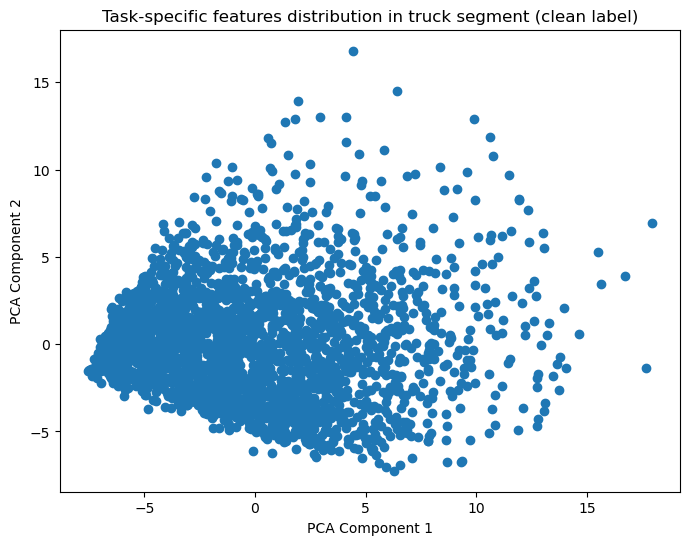

In [26]:
# reduce the dimension of task-specific features from 128 to 2
pca_1 = PCA(n_components=2)
clean_reduced_features = pca_1.fit_transform(Tensor.cpu(segment_clean_feature).numpy())

plt.figure(figsize=(8, 6))
plt.scatter(clean_reduced_features[:, 0], clean_reduced_features[:, 1])
plt.title("Task-specific features distribution in truck segment (clean label)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

### 2-b. Perform PCA on task-specific features of the poisoned label

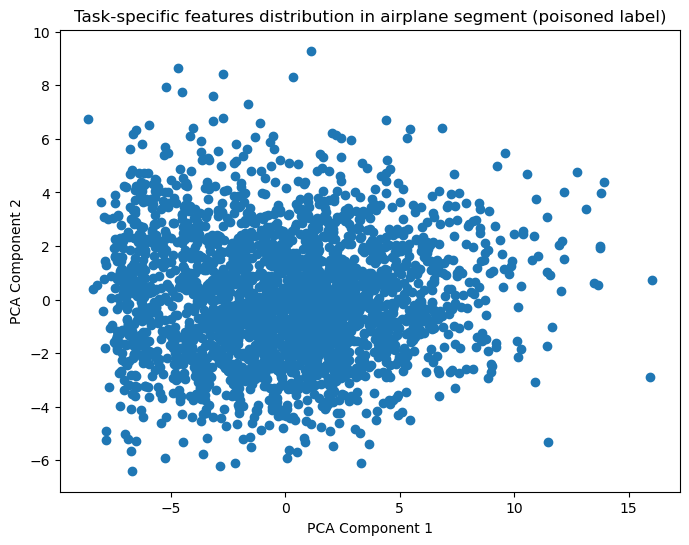

In [27]:
# reduce the dimension of task-specific features from 128 to 2
pca_2 = PCA(n_components=2)
poisoned_reduced_features = pca_2.fit_transform(Tensor.cpu(segment_poisoned_feature).numpy())

plt.figure(figsize=(8, 6))
plt.scatter(poisoned_reduced_features[:, 0], poisoned_reduced_features[:, 1])
plt.title("Task-specific features distribution in airplane segment (poisoned label)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

## 3. Perform K-mean clustering

### 3-a. Perform K-mean clustering on the clean data

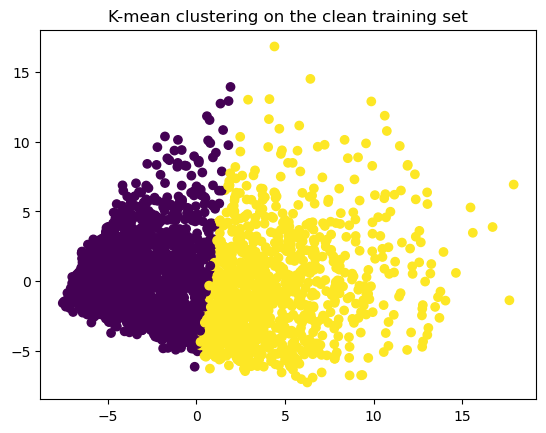

In [28]:
y_pred = KMeans(n_clusters=2, n_init=10, random_state=2).fit_predict(X=clean_reduced_features)
# print(y_pred.shape)
plt.scatter(clean_reduced_features[:, 0], clean_reduced_features[:, 1], c= y_pred)
plt.title("K-mean clustering on the clean training set")
plt.show()

### 3-b. Perform K-mean clustering on the poisoned data

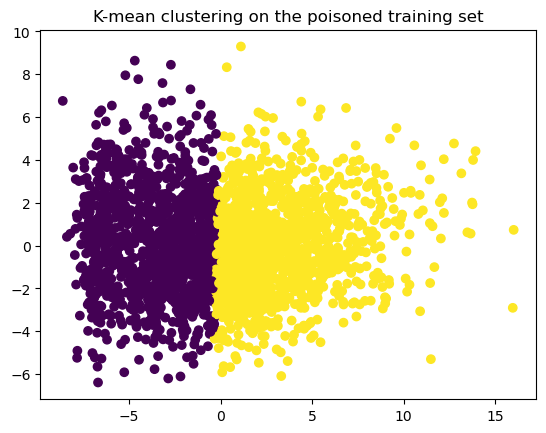

In [29]:
y_pred = KMeans(n_clusters=2, n_init=10, random_state=2).fit_predict(X=poisoned_reduced_features)
# print(y_pred.shape) 
plt.scatter(poisoned_reduced_features[:, 0], poisoned_reduced_features[:, 1], c= y_pred)
plt.title("K-mean clustering on the poisoned training set")
plt.show()